# Commodity mapping with openEO and CDSE


## 1. Introduction

This notebook demonstrates how to:

- Select a spatial and temporal region using an interactive map.

- Query and retrieve a machine learning model from the STAC catalog.

- Load and normalize input satellite data using OpenEO.

- Run ML inference and visualize input and output data.

CDSE (Copernicus Data Space Ecosystem)
The CDSE is the platform hosting satellite imagery, processed data, and ML models. This notebook connects to the CDSE via OpenEO to fetch input data cubes and run processing jobs in the cloud. Make sure to create an account on the CDSE in order to be able to run this workflow: https://documentation.dataspace.copernicus.eu/Registration.html

New users to openEO are advised to first visit: https://github.com/Open-EO/openeo-community-examples/blob/main/python/1.%20GettingStarted/GettingStarted.ipynb



## 2. Interactive Spatial and Temporal Selection

Import necessary libraries and use the interactive UI to draw a bounding box (max 20×20 km) and select a year.
This sets the spatial and temporal extent in UTM coordinates, ready for OpenEO processing. UTM coordinates are required as the workflows assumes 10m resolution products

In [1]:
import openeo
import world_agrocommodities.classification.config as config
import utility as utility

# Step 1: Interactive UI
ui, result = utility.interactive_configurator()
ui

Retrieve the selections:

In [2]:
# SPATIAL_EXTENT = result["spatial_extent"]
# TEMPORAL_EXTENT = result["temporal_extent"]
# CRS = result["crs"]
# print(SPATIAL_EXTENT)
# spatial_extent = {
#        "west": 385000,
#        "south": 4848000,
#        "east": 395000,
#        "north": 4858000
#    }

# CRS = "EPSG:32737"

SPATIAL_EXTENT = {
    "west": 817475.0741295104,
    "south": -522776.47462956805,
    "east": 817838.336850123,
    "north": -522493.8634415434,
    "crs": "EPSG:32634",
}
TEMPORAL_EXTENT = ["2025-01-01", "2025-12-31"]
CRS = "EPSG:32634"

import requests
import pyproj


def utm_to_wgs84_bbox(bbox, crs):
    """
    Convert a UTM bbox to WGS84 [west, south, east, north].
    """
    transformer = pyproj.Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
    west, south = transformer.transform(bbox[0], bbox[1])
    east, north = transformer.transform(bbox[2], bbox[3])
    return [west, south, east, north]


def check_tcd_availability(spatial_extent, temporal_extent):
    """
    Query the Copernicus STAC API for Tree Cover Density availability.
    Converts spatial extent to EPSG:4326 and formats time properly.
    """

    # Convert bbox to EPSG:4326 if needed
    if spatial_extent.get("crs") and spatial_extent["crs"] != "EPSG:4326":
        bbox = utm_to_wgs84_bbox(
            [
                spatial_extent["west"],
                spatial_extent["south"],
                spatial_extent["east"],
                spatial_extent["north"],
            ],
            spatial_extent["crs"],
        )
    else:
        bbox = [
            spatial_extent["west"],
            spatial_extent["south"],
            spatial_extent["east"],
            spatial_extent["north"],
        ]

    # Format datetime range
    start, end = ["2020-01-01", "2020-12-31"]
    datetime_range = f"{start}T00:00:00Z/{end}T23:59:59Z"

    query = {
        "collections": ["LCFM_TCD-10_CDSE_v100"],
        "bbox": bbox,
        "datetime": datetime_range,
        "limit": 1,
    }

    url = "https://www.stac.lcfm.dataspace.copernicus.eu/search"
    response = requests.post(url, json=query)

    if not response.ok:
        print("Error:", response.status_code, response.text)
        return None

    data = response.json()
    features = data.get("features", [])

    if not features:
        print("No Tree Cover Density data found for given extent/time.")
        return None

    stac_item = features[0]
    print("STAC item found:")
    print(f"  ID: {stac_item.get('id')}")
    print(f"  Collection: {stac_item.get('collection')}")
    print(f"  Bounding box: {stac_item.get('bbox')}")
    print(f"  Time: {stac_item['properties'].get('datetime')}")

    return stac_item


check_tcd_availability(SPATIAL_EXTENT, TEMPORAL_EXTENT)

STAC item found:
  ID: LCFM_TCD-10_V100_2020_S06E021_MAP
  Collection: LCFM_TCD-10_CDSE_v100
  Bounding box: [21.0, -6.0, 24.0, -3.0]
  Time: 2020-01-01T00:00:00Z


{'id': 'LCFM_TCD-10_V100_2020_S06E021_MAP',
 'bbox': [21.0, -6.0, 24.0, -3.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://www.stac.lcfm.dataspace.copernicus.eu/collections/LCFM_TCD-10_CDSE_v100'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://www.stac.lcfm.dataspace.copernicus.eu/collections/LCFM_TCD-10_CDSE_v100'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://www.stac.lcfm.dataspace.copernicus.eu/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://www.stac.lcfm.dataspace.copernicus.eu/collections/LCFM_TCD-10_CDSE_v100/items/LCFM_TCD-10_V100_2020_S06E021_MAP'}],
 'assets': {'MAP': {'href': 's3://eodata/CLMS/landcover_landuse/dynamic_land_cover/tcd_pantropical_10m_yearly_v1/2020/01/01/LCFM_TCD-10_V100_2020_S06E021_cog/LCFM_TCD-10_V100_2020_S06E021_MAP.tif',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
   'roles': ['data'],
   't

## 3. Fetch Model Metadata

We have created a STAC collection which contains all relevant meta information for the available models for commodity mapping. Currently we have 3 models available; 1 for Africa, 1 for South America and one for South-East Asia. You can browse the catalogue at:

https://radiantearth.github.io/stac-browser/#/external/stac.openeo.vito.be/collections/world-agri-commodities-models?.language=en

each model is represented by an item. 

In the future we aim to expand this STAC collection and add meta-information on the accuracy of each model per commodity; thereby ensuring that our models and their performance is transparant. 

Below we query the STAC catalog for the ML model relevant to your region and period:

In [3]:
from world_agrocommodities.model_stac import get_model_id, get_model_metadata

model_id = get_model_id(SPATIAL_EXTENT, TEMPORAL_EXTENT)

model_metadata = get_model_metadata(model_id)
print(model_metadata)

STAC Item found:
  ID: WorldAgriCommodities_Africa_v1
Model metadata retrieved.
{'ModelID': None, 'Name': None, 'Region': 'Africa', 'Countries Covered': None, 'Framework': 'ONNX', 'Input Shape': 17, 'Output Shape': 25, 'Input Channels': ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B11', 'B12', 'NDVI', 'NDRE', 'EVI', 'VV', 'VH', 'DEM', 'lon', 'lat'], 'Output Classes': ['Background', 'Other_large_scale_cropland', 'Pasture', 'Mining', 'Other_small_scale_cropland', 'Roads', 'Forest', 'Plantation_forest', 'Coffee', 'Build_up', 'Water', 'Oil_palm', 'Rubber', 'Cacao', 'Avocado', 'Soy', 'Sugar', 'Maize', 'Banana', 'Pineapple', 'Rice', 'Wood_logging', 'Cashew', 'Tea', 'Others'], 'Time of Data begins': '2020-01-01T00:00:00Z', 'Time of Data ends': '2030-12-31T00:00:00Z'}


## 4. Create the normalized input Process Graph 

Below we authenticate to the CDSE backend; as a first time user you will receive a https request to log-in when running `connection.authenticate_oidc()`. Ensure that you click the link, or log in through the web browser to continue. 

A utility function `load_input_cube` has been created which builds the required input data based on the parameters optained from the interactactive UI and preset parameters defined in `config.py`. It is advised to not change the parameters set in the configuration file.

Running this cell will create a process graph, but the job itself will not be launched yet

In [4]:
from world_agrocommodities.classification import (
    load_input_cube,
    normalize_cube,
    run_inference,
)

connection = openeo.connect("https://openeo.dataspace.copernicus.eu/")
connection.authenticate_oidc()


input_cube = load_input_cube(
    connection,
    spatial_extent=SPATIAL_EXTENT,
    temporal_extent=TEMPORAL_EXTENT,
    max_cloud_cover=config.MAX_CLOUD_COVER,
    resolution=config.RESOLUTION,
    quantile=config.QUANTILE,
    crs=CRS,
)

Authenticated using refresh token.


# 5. Load Input Data [OPTIONAL]

If you wish to investigate the input data you can execute the two cells below; these will run the actual openEO job and visualise the output of the normalization procedure

In [5]:
input_save_cube = input_cube.save_result(format="netCDF")
job = connection.create_job(
    title="test_norm_with_STAC",
    process_graph=input_save_cube,
    additional=config.JOB_OPTIONS,
)
job.start_and_wait()

0:00:00 Job 'j-251121091734426eacd03a5146556335': send 'start'
0:00:14 Job 'j-251121091734426eacd03a5146556335': created (progress 0%)
0:00:20 Job 'j-251121091734426eacd03a5146556335': created (progress 0%)
0:00:28 Job 'j-251121091734426eacd03a5146556335': created (progress 0%)
0:00:37 Job 'j-251121091734426eacd03a5146556335': running (progress N/A)
0:00:47 Job 'j-251121091734426eacd03a5146556335': running (progress N/A)
0:01:00 Job 'j-251121091734426eacd03a5146556335': running (progress N/A)
0:01:15 Job 'j-251121091734426eacd03a5146556335': running (progress N/A)
0:01:36 Job 'j-251121091734426eacd03a5146556335': running (progress N/A)
0:02:02 Job 'j-251121091734426eacd03a5146556335': running (progress N/A)
0:02:32 Job 'j-251121091734426eacd03a5146556335': running (progress N/A)
0:03:11 Job 'j-251121091734426eacd03a5146556335': running (progress N/A)
0:03:58 Job 'j-251121091734426eacd03a5146556335': running (progress N/A)
0:04:59 Job 'j-251121091734426eacd03a5146556335': finished (prog

<BatchJob job_id='j-251121091734426eacd03a5146556335'>

Plotting mode: input


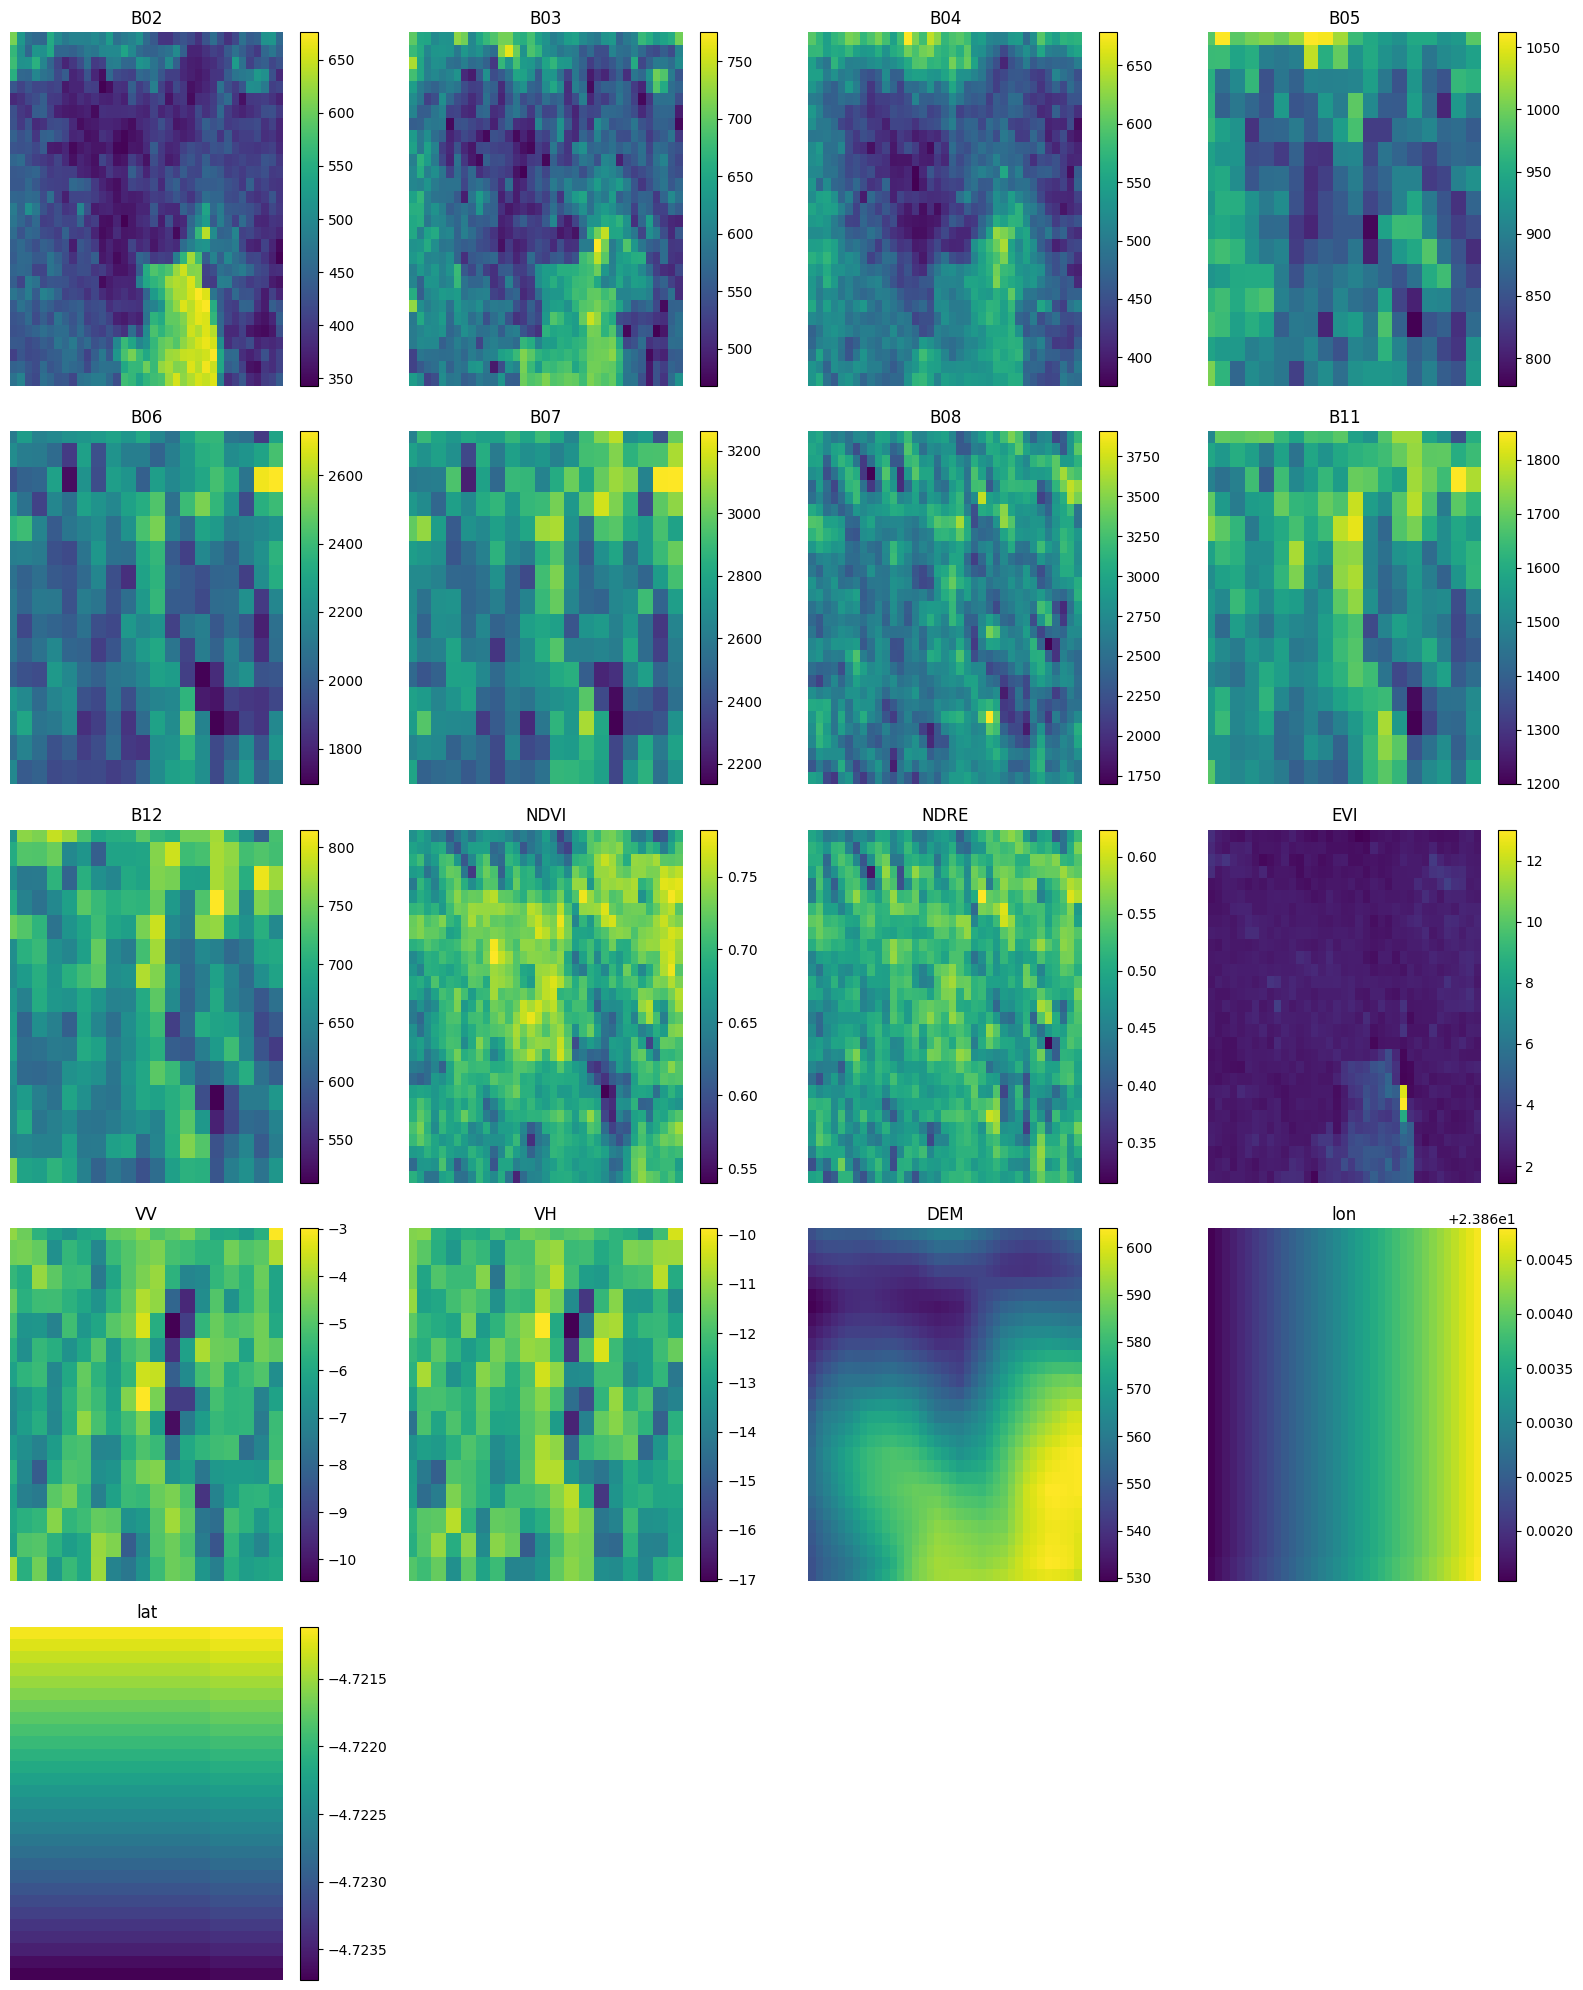

In [6]:
utility.plot_job_results(job, output_dir="~/openeo_results", time_step=0, mode="input")

# 6. Create ML Inference Process Graph

Below we use created the normalized input cube and use openEO to run the ML inference on the AOI using the `run_inference`utility function. 
Executing this cell will only create the process graph. 

In [7]:
from world_agrocommodities.classification import (
    add_tree_cover_density,
)

# Normalize input cube for ML inference
cube_normalised = normalize_cube(input_cube, model_id=model_id)

# Run inference
inference_cube = run_inference(
    cube_normalised,
    model_id=model_id,
    patch_size=config.PATCH_SIZE,
    overlap=config.OVERLAP_SIZE,
)

# Add tree cover density layer
inference_cube = add_tree_cover_density(
    connection=connection,
    cube=inference_cube,
    spatial_extent=SPATIAL_EXTENT,
    crs=CRS,
)

save_inference_cube = inference_cube.save_result(format="netCDF")
save_inference_cube

Deriving band listing from unordered `item_assets`
The specified bands ['MAP'] in `load_stac` are not a subset of the bands [] found in the STAC metadata (unknown bands: ['MAP']). Working with specified bands as is.


## 7. Submit Inference Cube Job

In [8]:
job = connection.create_job(
    title="Example WAC Inference with Tree Cover Density",
    process_graph=save_inference_cube,
    additional=config.JOB_OPTIONS,
)
job.start_and_wait()

0:00:00 Job 'j-25112109535341cf84d39497f75847f3': send 'start'
0:00:15 Job 'j-25112109535341cf84d39497f75847f3': created (progress 0%)
0:00:20 Job 'j-25112109535341cf84d39497f75847f3': running (progress N/A)
0:00:26 Job 'j-25112109535341cf84d39497f75847f3': running (progress N/A)
0:00:34 Job 'j-25112109535341cf84d39497f75847f3': running (progress N/A)
0:00:44 Job 'j-25112109535341cf84d39497f75847f3': running (progress N/A)
0:00:58 Job 'j-25112109535341cf84d39497f75847f3': running (progress N/A)
0:01:14 Job 'j-25112109535341cf84d39497f75847f3': running (progress N/A)
0:01:35 Job 'j-25112109535341cf84d39497f75847f3': running (progress N/A)
0:02:00 Job 'j-25112109535341cf84d39497f75847f3': running (progress N/A)
0:02:30 Job 'j-25112109535341cf84d39497f75847f3': running (progress N/A)
0:03:09 Job 'j-25112109535341cf84d39497f75847f3': running (progress N/A)
0:03:57 Job 'j-25112109535341cf84d39497f75847f3': running (progress N/A)
0:04:55 Job 'j-25112109535341cf84d39497f75847f3': finished (pr

<BatchJob job_id='j-25112109535341cf84d39497f75847f3'>

# 8. Visualize Output Classification

Plotting mode: output


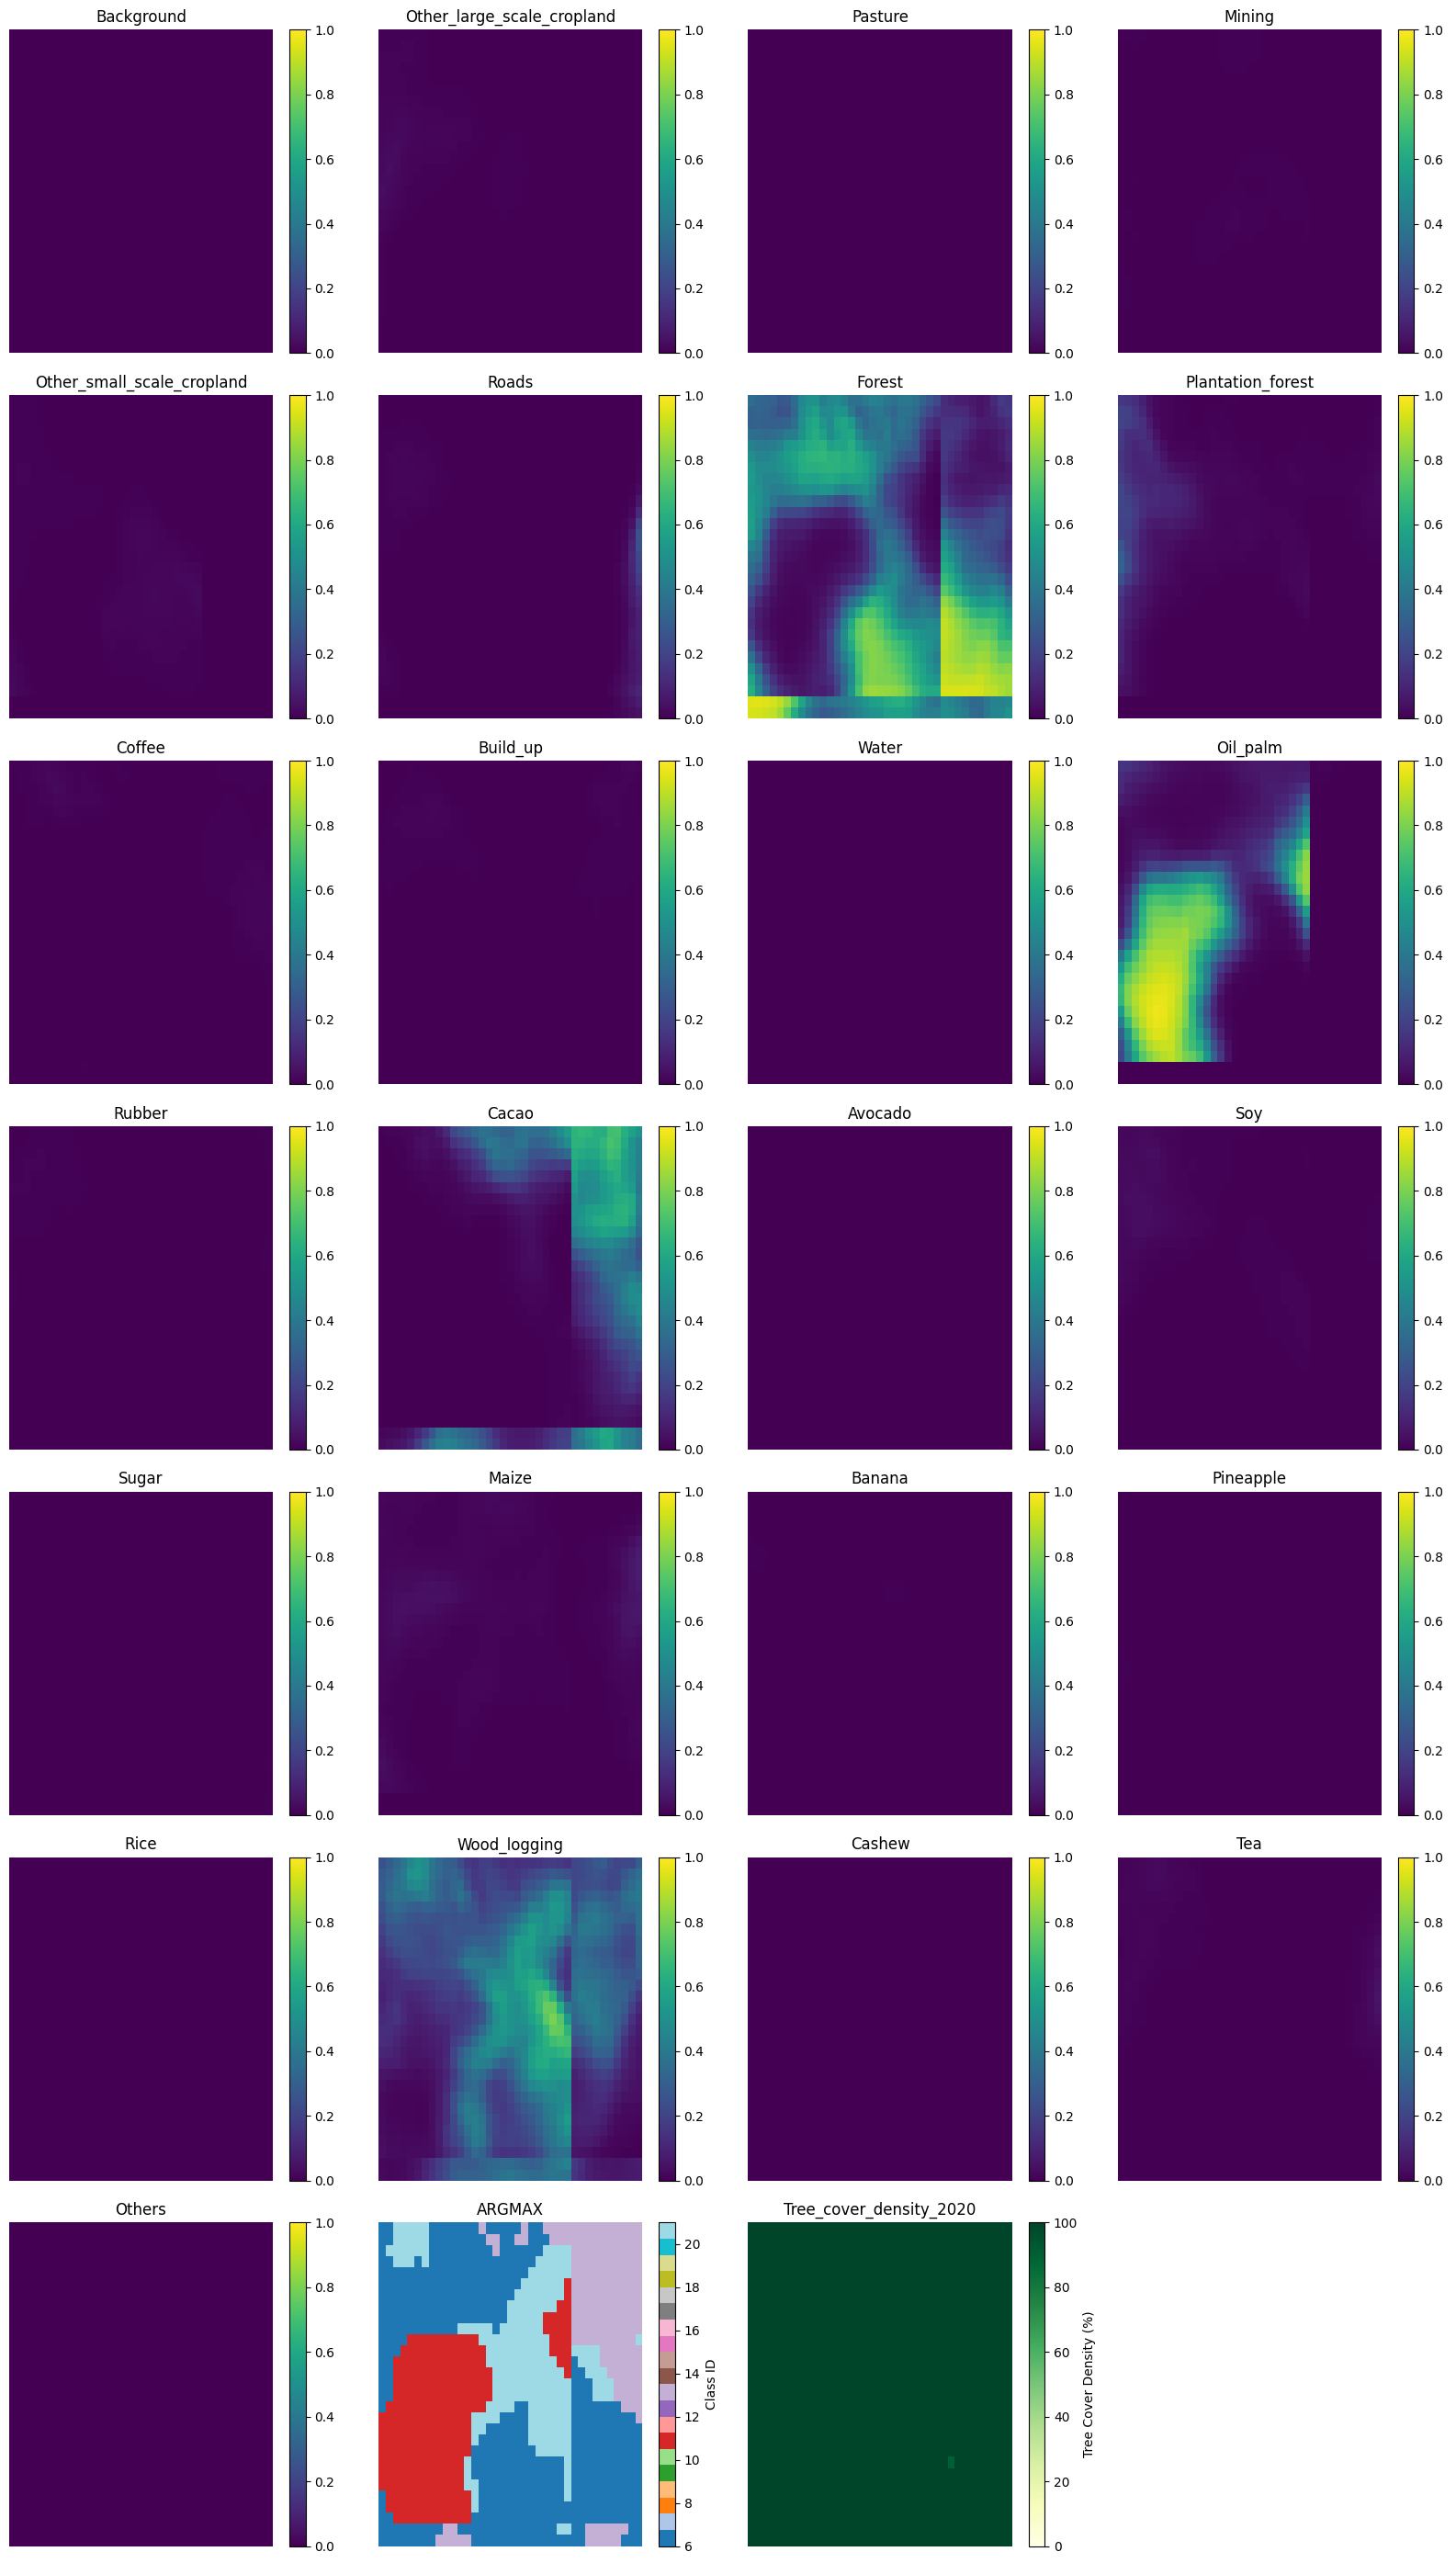

In [9]:
utility.plot_job_results(job, output_dir="~/openeo_results", time_step=0, mode="output")

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

ncols = 4
time_step = 0

ds = xr.open_dataset(
    r"C:\Users\VROMPAYH\openeo_results\j-2511120926274f639aeadd350254cbce\openEO.nc"
)

variables_to_plot = [
    var for var in ds.data_vars if {"t", "y", "x"}.issubset(ds[var].dims)
]


n = len(variables_to_plot)
nrows = -(-n // ncols)  # ceiling division
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
axes = axes.flatten()


classification_var = "ARGMAX"
tree_cover_var = "Tree_cover_density_2020"

for i, var in enumerate(variables_to_plot):
    if var not in ds:
        continue

    data = ds[var].isel(t=time_step)
    ax = axes[i]

    if var == classification_var:
        # Discrete classification map
        im = data.plot(
            ax=ax,
            cmap="tab20",
            add_colorbar=True,
            add_labels=False,
        )
        cbar = im.colorbar
        cbar.set_label("Class ID")
    elif var == tree_cover_var:
        # Continuous 0–100 map
        im = data.plot(
            ax=ax,
            cmap="YlGn",
            vmin=0,
            vmax=100,
            add_colorbar=True,
            add_labels=False,
        )
        cbar = im.colorbar
        cbar.set_label("Tree Cover Density (%)")
    else:
        # Probability or continuous confidence-like layers (0–1)
        im = data.plot(
            ax=ax,
            cmap="viridis",
            vmin=0,
            vmax=1,
            add_colorbar=True,
            add_labels=False,
        )

    ax.set_title(var)
    ax.axis("off")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()


plt.show()